# YOLO Evaluation

## Prepare Dataset for YOLO

In [ ]:
# import os
# import pandas as pd
# import cv2

# # Paths (adjusted for your setup)
# kaggle_data_dir = "/content/drive/My Drive/cv_final_project"  # Base directory in your Google Drive
# test_labels_csv = os.path.join(kaggle_data_dir, "test_labels.csv")  # CSV file with annotations
# test_images_dir = os.path.join(kaggle_data_dir, "cars_test")  # Directory with test images
# test_labels_dir = os.path.join(kaggle_data_dir, "cars_test")  # Output directory for YOLO labels

# # Create directory for test labels
# os.makedirs(test_labels_dir, exist_ok=True)

# # Function to convert annotations
# def convert_annotations(csv_file, images_src_dir, labels_dst_dir):
#     df = pd.read_csv(csv_file)  # Read CSV file with annotations
#     for _, row in df.iterrows():
#         image_name = row['image']  # Image file name
#         class_id = 0  # Assuming one class ('car')
#         x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']  # Bounding box coordinates

#         # Load image to get dimensions
#         img_path = os.path.join(images_src_dir, image_name)
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Warning: Could not read image {img_path}")
#             continue
#         height, width, _ = img.shape

#         # Convert bounding box coordinates to YOLO format
#         x_center = ((x1 + x2) / 2) / width
#         y_center = ((y1 + y2) / 2) / height
#         bbox_width = (x2 - x1) / width
#         bbox_height = (y2 - y1) / height

#         # Create YOLO label file
#         label_path = os.path.join(labels_dst_dir, image_name.replace('.jpg', '.txt'))
#         with open(label_path, 'w') as f:
#             f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# # Convert test annotations to YOLO format
# convert_annotations(
#     csv_file=test_labels_csv,  # Path to test_labels.csv
#     images_src_dir=test_images_dir,  # Path to test images
#     labels_dst_dir=test_labels_dir  # Path to output YOLO label files
# )

# print("Test annotations successfully converted to YOLO format!")

## Pre-trained Model - Predictions

In [ ]:
# !pip install ultralytics opencv-python

In [ ]:
# Import necessary libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import glob
from ultralytics.utils.metrics import bbox_iou
import os
import numpy as np
import torch

# Define paths
# Path to the fine-tuned model
fine_tuned_model_path = "/content/drive/My Drive/cv_final_project/yolov8_car_detection_ks.pt"
# Path to the pre-trained YOLO model
pretrained_model_path = "yolov8n.pt"  # Automatically downloads the pre-trained YOLOv8 Nano model
# Path to the test dataset
test_data_path = "/content/drive/My Drive/cv_final_project/cars_test"
# Path to the data.yaml file
data_yaml_path = "/content/drive/My Drive/cv_final_project/data.yaml"

# Get all test images
image_paths = glob.glob(f"{test_data_path}/*.jpg")  # Get all images in the test dataset

In [ ]:
# Load the pre-trained YOLO model
pretrained_model = YOLO(pretrained_model_path)

# Store IoU, confidence, and ground truth counts
ious = []
confidences = []
ground_truths_count = 0
predictions_count = 0
precision_recall_points = []

for idx, image_path in enumerate(image_paths, start=1):
    try:
        print(f"Processing image {idx}/{len(image_paths)}: {image_path}")

        # Perform predictions
        result = pretrained_model.predict(
            source=image_path,
            save=False,
            imgsz=640,
            classes=[2],  # Restrict to 'car' class
            conf=0.25     # Confidence threshold
        )

        # Find the most confident box
        if result[0].boxes:
            boxes = result[0].boxes
            most_confident_box = max(boxes, key=lambda box: box.conf.cpu().item())
            pred_box = most_confident_box.xywhn.cpu().numpy()[0]
            confidence = most_confident_box.conf.cpu().item()
            confidences.append(confidence)
            predictions_count += 1

            # Load Ground Truth
            label_path = os.path.splitext(image_path)[0] + ".txt"
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    ground_truths = [list(map(float, line.strip().split()[1:])) for line in f.readlines()]
                    ground_truths_count += len(ground_truths)

                # Calculate IoUs and store the max IoU
                iou = max([bbox_iou(torch.tensor(pred_box), torch.tensor(gt), xywh=True).item() for gt in ground_truths], default=0)
                ious.append((iou, confidence))  # Store IoU and confidence for AP calculation

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        continue

Streaming output truncated to the last 5000 lines.
Processing image 6949/8198: /content/drive/My Drive/cv_final_project/cars_test/04016.jpg

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/04016.jpg: 448x640 1 car, 265.4ms
Speed: 8.7ms preprocess, 265.4ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)
Processing image 6950/8198: /content/drive/My Drive/cv_final_project/cars_test/03896.jpg

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/03896.jpg: 448x640 2 cars, 252.8ms
Speed: 3.5ms preprocess, 252.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
Processing image 6951/8198: /content/drive/My Drive/cv_final_project/cars_test/02858.jpg

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/02858.jpg: 448x640 1 car, 253.7ms
Speed: 3.5ms preprocess, 253.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Processing image 6952/8198: /content/drive/My Drive/cv_final_project/cars_test/06405.jpg

image 1/1

In [ ]:
# Calculate metrics
threshold = 0.5  # IoU threshold
true_positives = sum(iou >= threshold for iou, _ in ious)
false_positives = predictions_count - true_positives
false_negatives = ground_truths_count - true_positives

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
mean_iou = sum(iou for iou, _ in ious) / len(ious) if ious else 0

# Calculate AP
sorted_ious = sorted(ious, key=lambda x: x[1], reverse=True)  # Sort by confidence
tp_cumsum = np.cumsum([iou >= threshold for iou, _ in sorted_ious])
fp_cumsum = np.cumsum([iou < threshold for iou, _ in sorted_ious])

precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
recalls = tp_cumsum / ground_truths_count if ground_truths_count > 0 else np.zeros_like(tp_cumsum)
average_precision = np.trapz(precisions, recalls) if len(recalls) > 1 else 0

# Output results
print(f"Custom Evaluation Results:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Mean IoU: {mean_iou:.4f}")
print(f"  AP (Average Precision): {average_precision:.4f}")

Custom Evaluation Results:
  Precision: 0.8011
  Recall: 0.8168
  Mean IoU: 0.7767
  AP (Average Precision): 0.7424


## Fine-tuned Model - Predictions

In [ ]:
# Load the fine-tuned YOLO model
fine_tuned_model = YOLO(fine_tuned_model_path)

# Store IoU, confidence, and ground truth counts
fine_ious = []
fine_confidences = []
fine_ground_truths_count = 0
fine_predictions_count = 0

for idx, image_path in enumerate(image_paths, start=1):
    try:
        print(f"Processing image {idx}/{len(image_paths)}: {image_path}")

        # Perform predictions
        result = fine_tuned_model.predict(
            source=image_path,
            save=False,
            imgsz=640,
            classes=[0],  # Assuming class 0 for 'car' in the fine-tuned model
            conf=0.25     # Confidence threshold
        )

        # Find the most confident box
        if result[0].boxes:
            boxes = result[0].boxes
            most_confident_box = max(boxes, key=lambda box: box.conf.cpu().item())
            pred_box = most_confident_box.xywhn.cpu().numpy()[0]
            confidence = most_confident_box.conf.cpu().item()
            fine_confidences.append(confidence)
            fine_predictions_count += 1

            # Load Ground Truth
            label_path = os.path.splitext(image_path)[0] + ".txt"
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    ground_truths = [list(map(float, line.strip().split()[1:])) for line in f.readlines()]
                    fine_ground_truths_count += len(ground_truths)

                # Calculate IoUs and store the max IoU
                iou = max([bbox_iou(torch.tensor(pred_box), torch.tensor(gt), xywh=True).item() for gt in ground_truths], default=0)
                fine_ious.append((iou, confidence))  # Store IoU and confidence for AP calculation

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        continue

Streaming output truncated to the last 5000 lines.
Processing image 6949/8198: /content/drive/My Drive/cv_final_project/cars_test/04016.jpg

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/04016.jpg: 448x640 1 car, 165.2ms
Speed: 4.4ms preprocess, 165.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Processing image 6950/8198: /content/drive/My Drive/cv_final_project/cars_test/03896.jpg

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/03896.jpg: 448x640 1 car, 161.3ms
Speed: 4.0ms preprocess, 161.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Processing image 6951/8198: /content/drive/My Drive/cv_final_project/cars_test/02858.jpg

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/02858.jpg: 448x640 1 car, 230.8ms
Speed: 3.3ms preprocess, 230.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Processing image 6952/8198: /content/drive/My Drive/cv_final_project/cars_test/06405.jpg

image 1/1 

In [ ]:
# Calculate metrics for the fine-tuned model
threshold = 0.5  # IoU threshold
fine_true_positives = sum(iou >= threshold for iou, _ in fine_ious)
fine_false_positives = fine_predictions_count - fine_true_positives
fine_false_negatives = fine_ground_truths_count - fine_true_positives

fine_precision = fine_true_positives / (fine_true_positives + fine_false_positives) if (fine_true_positives + fine_false_positives) > 0 else 0
fine_recall = fine_true_positives / (fine_true_positives + fine_false_negatives) if (fine_true_positives + fine_false_negatives) > 0 else 0
fine_mean_iou = sum(iou for iou, _ in fine_ious) / len(fine_ious) if fine_ious else 0

# Calculate AP for the fine-tuned model
fine_sorted_ious = sorted(fine_ious, key=lambda x: x[1], reverse=True)  # Sort by confidence
fine_tp_cumsum = np.cumsum([iou >= threshold for iou, _ in fine_sorted_ious])
fine_fp_cumsum = np.cumsum([iou < threshold for iou, _ in fine_sorted_ious])

fine_precisions = fine_tp_cumsum / (fine_tp_cumsum + fine_fp_cumsum)
fine_recalls = fine_tp_cumsum / fine_ground_truths_count if fine_ground_truths_count > 0 else np.zeros_like(fine_tp_cumsum)
fine_average_precision = np.trapz(fine_precisions, fine_recalls) if len(fine_recalls) > 1 else 0

# Output results for the fine-tuned model
print(f"Fine-Tuned Model Evaluation Results:")
print(f"  Precision: {fine_precision:.4f}")
print(f"  Recall: {fine_recall:.4f}")
print(f"  Mean IoU: {fine_mean_iou:.4f}")
print(f"  AP (Average Precision): {fine_average_precision:.4f}")

Fine-Tuned Model Evaluation Results:
  Precision: 0.9794
  Recall: 0.9985
  Mean IoU: 0.9547
  AP (Average Precision): 0.9982


## Bar chart to compare

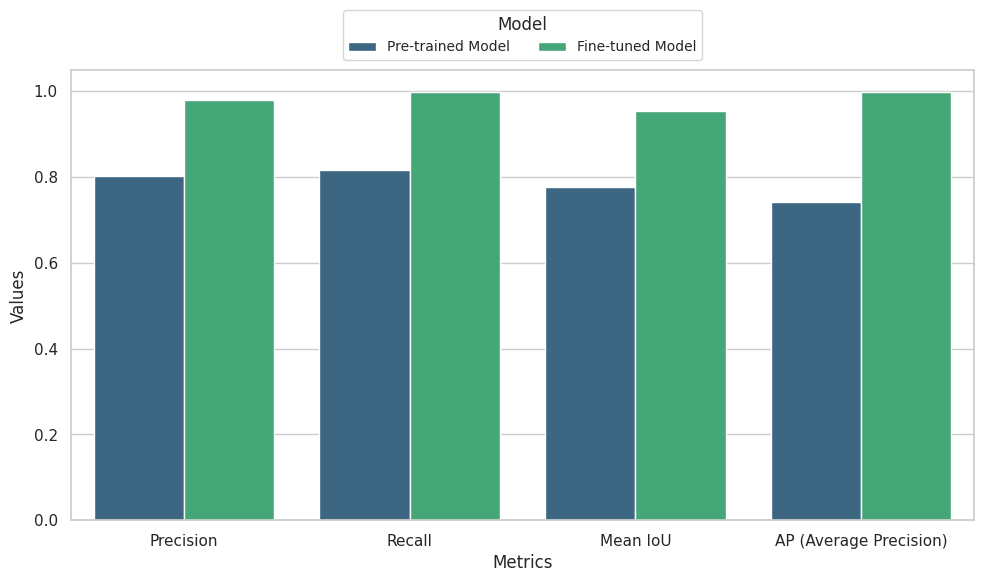

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Dynamically assign metrics for pre-trained and fine-tuned models
data = {
    "Metrics": ['Precision', 'Recall', 'Mean IoU', 'AP (Average Precision)'],
    "Pre-trained Model": [
        precision, recall, mean_iou, average_precision
    ],
    "Fine-tuned Model": [
        fine_precision, fine_recall, fine_mean_iou, fine_average_precision
    ]
}

# Convert data to a DataFrame for seaborn
df = pd.DataFrame(data)

# Melt DataFrame for seaborn bar plot
df_melted = df.melt(id_vars="Metrics", var_name="Model", value_name="Value")

# Set seaborn style
sns.set_theme(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(
    data=df_melted, x="Metrics", y="Value", hue="Model", palette="viridis"
)

# Customize labels and title
bar_plot.set_title("", fontsize=14)
bar_plot.set_xlabel("Metrics", fontsize=12)
bar_plot.set_ylabel("Values", fontsize=12)

# Move the legend above the plot
bar_plot.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, title="Model", fontsize=10)

# Alternatively, move the legend below the plot (uncomment this line if preferred)
# bar_plot.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2, title="Model", fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

## Visualize YOLO results

In [ ]:
import cv2
import matplotlib.pyplot as plt

def visualize_most_confident_boxes(image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.25):
    """
    Visualize the most confident bounding boxes from pre-trained and fine-tuned YOLO models.

    Args:
        image_path (str): Path to the input image.
        pretrained_model_path (str): Path to the pre-trained YOLO model.
        fine_tuned_model_path (str): Path to the fine-tuned YOLO model.
        conf_threshold (float): Confidence threshold for predictions.
    """
    # Load the YOLO models
    pretrained_model = YOLO(pretrained_model_path)
    fine_tuned_model = YOLO(fine_tuned_model_path)

    # Perform predictions
    pretrained_results = pretrained_model.predict(source=image_path, save=False, imgsz=640, conf=conf_threshold)
    fine_tuned_results = fine_tuned_model.predict(source=image_path, save=False, imgsz=640, conf=conf_threshold)

    # Load the input image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Draw the most confident bounding box for the pre-trained model
    pretrained_image = image.copy()
    if pretrained_results[0].boxes:
        most_confident_box = max(pretrained_results[0].boxes, key=lambda box: box.conf.cpu().item())
        coords = most_confident_box.xyxy.cpu().numpy()[0]  # [x1, y1, x2, y2]
        confidence = most_confident_box.conf.cpu().item()
        label = f"Pre: {confidence:.2f}"
        cv2.rectangle(pretrained_image, (int(coords[0]), int(coords[1])), (int(coords[2]), int(coords[3])), (255, 0, 0), 2)
        cv2.putText(pretrained_image, label, (int(coords[0]), int(coords[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Draw the most confident bounding box for the fine-tuned model
    fine_tuned_image = image.copy()
    if fine_tuned_results[0].boxes:
        most_confident_box = max(fine_tuned_results[0].boxes, key=lambda box: box.conf.cpu().item())
        coords = most_confident_box.xyxy.cpu().numpy()[0]  # [x1, y1, x2, y2]
        confidence = most_confident_box.conf.cpu().item()
        label = f"Fine: {confidence:.2f}"
        cv2.rectangle(fine_tuned_image, (int(coords[0]), int(coords[1])), (int(coords[2]), int(coords[3])), (0, 255, 0), 2)
        cv2.putText(fine_tuned_image, label, (int(coords[0]), int(coords[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Plot the images for comparison
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(pretrained_image)
    plt.title("Pre-trained Model")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(fine_tuned_image)
    plt.title("Fine-tuned Model")
    plt.axis("off")

    plt.show()


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00010.jpg: 480x640 2 cars, 178.5ms
Speed: 2.4ms preprocess, 178.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00010.jpg: 480x640 1 car, 164.9ms
Speed: 2.4ms preprocess, 164.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


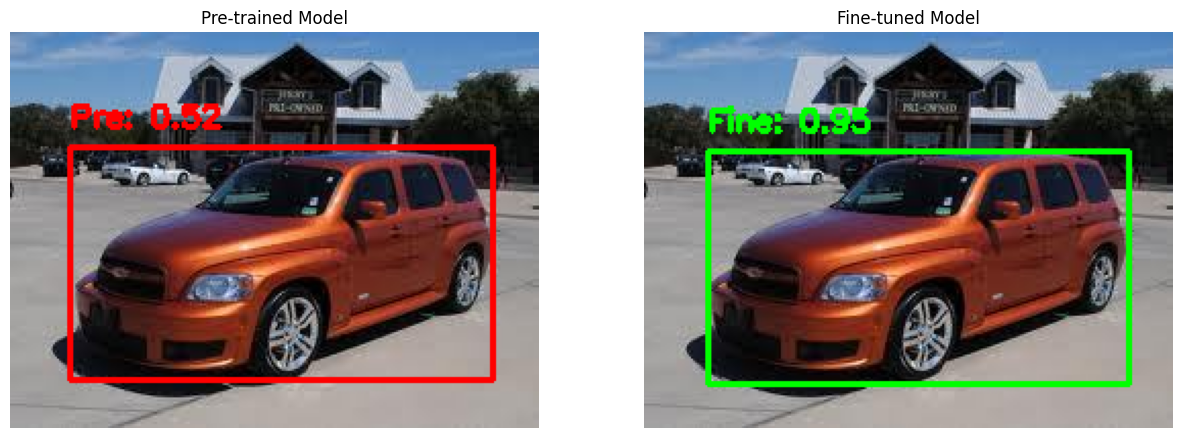

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/00010.jpg"
pretrained_model_path = "yolov8n.pt"
fine_tuned_model_path = "/content/drive/My Drive/cv_final_project/yolov8_car_detection_ks.pt"

visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.5)


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00012.jpg: 480x640 1 truck, 179.2ms
Speed: 2.5ms preprocess, 179.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00012.jpg: 480x640 1 car, 163.0ms
Speed: 2.6ms preprocess, 163.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


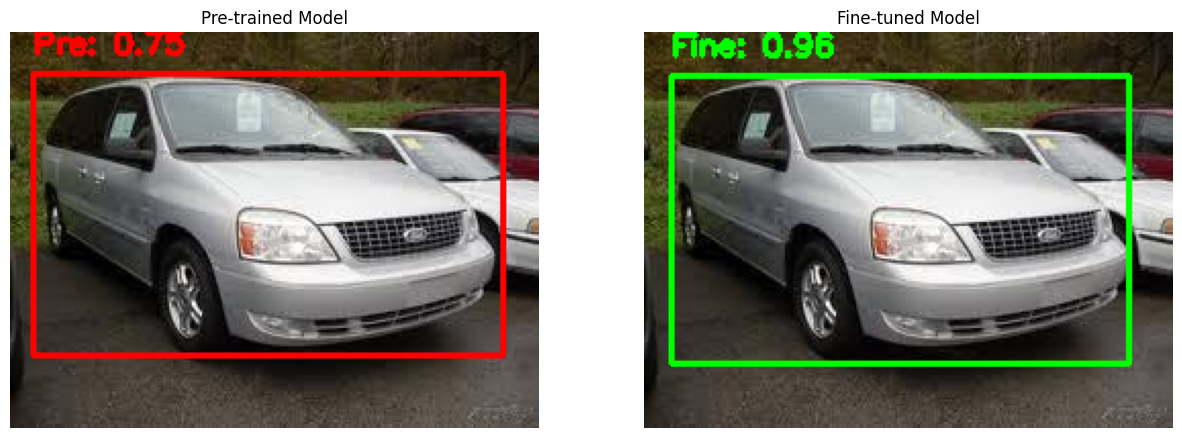

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/00012.jpg"
visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.5)


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00013.jpg: 448x640 1 car, 1 truck, 268.5ms
Speed: 3.8ms preprocess, 268.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00013.jpg: 448x640 1 car, 155.2ms
Speed: 2.6ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


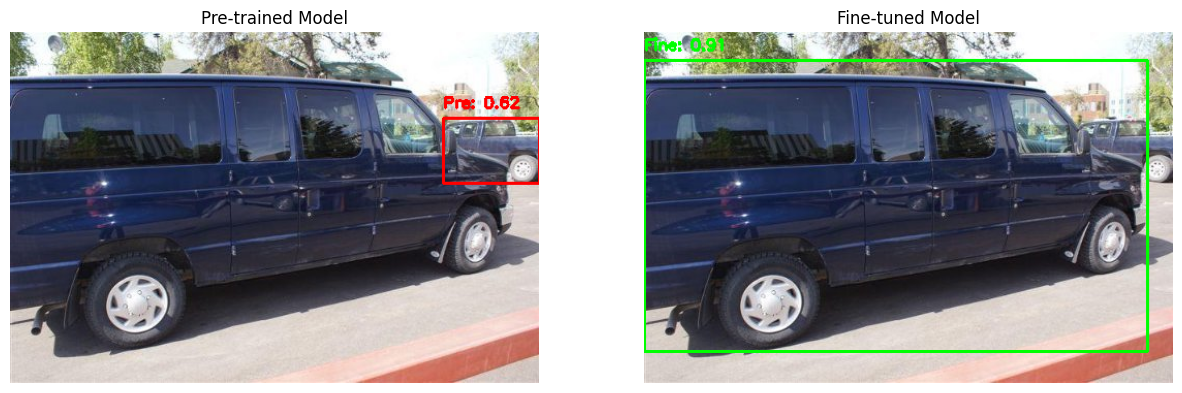

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/00013.jpg"
visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.5)


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00017.jpg: 448x640 1 truck, 252.6ms
Speed: 2.2ms preprocess, 252.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00017.jpg: 448x640 1 car, 231.8ms
Speed: 2.3ms preprocess, 231.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


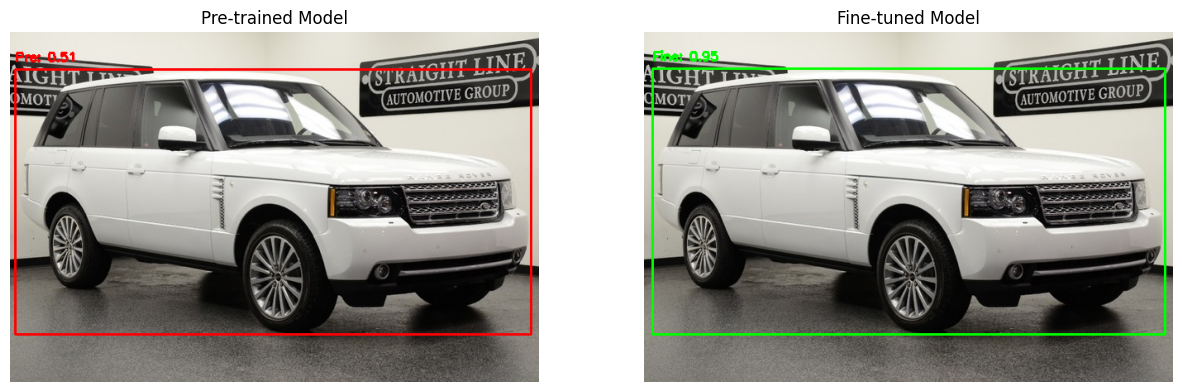

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/00017.jpg"
visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.5)


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00023.jpg: 480x640 4 cars, 168.8ms
Speed: 3.5ms preprocess, 168.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00023.jpg: 480x640 1 car, 178.8ms
Speed: 3.5ms preprocess, 178.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


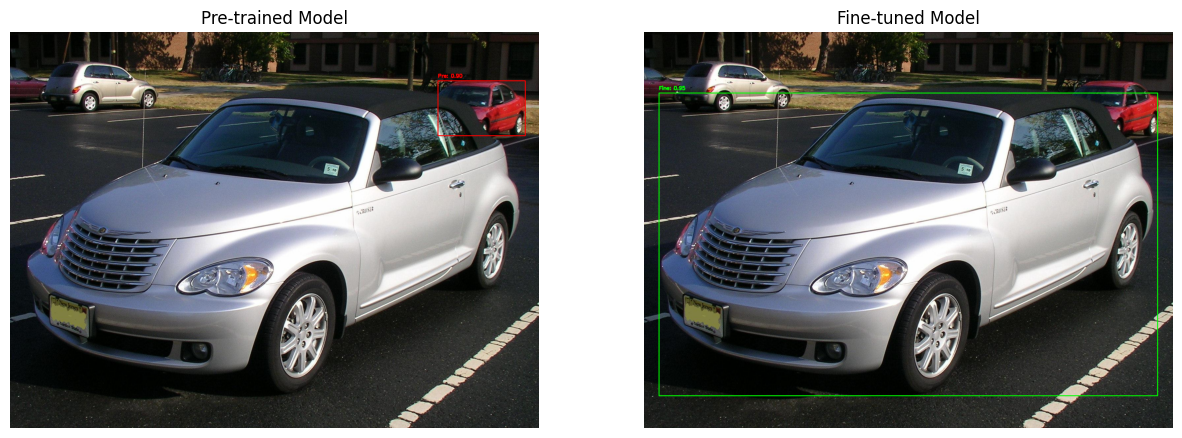

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/00023.jpg"
visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.5)


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00024.jpg: 480x640 1 car, 1 train, 204.1ms
Speed: 3.5ms preprocess, 204.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00024.jpg: 480x640 1 car, 167.5ms
Speed: 2.4ms preprocess, 167.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


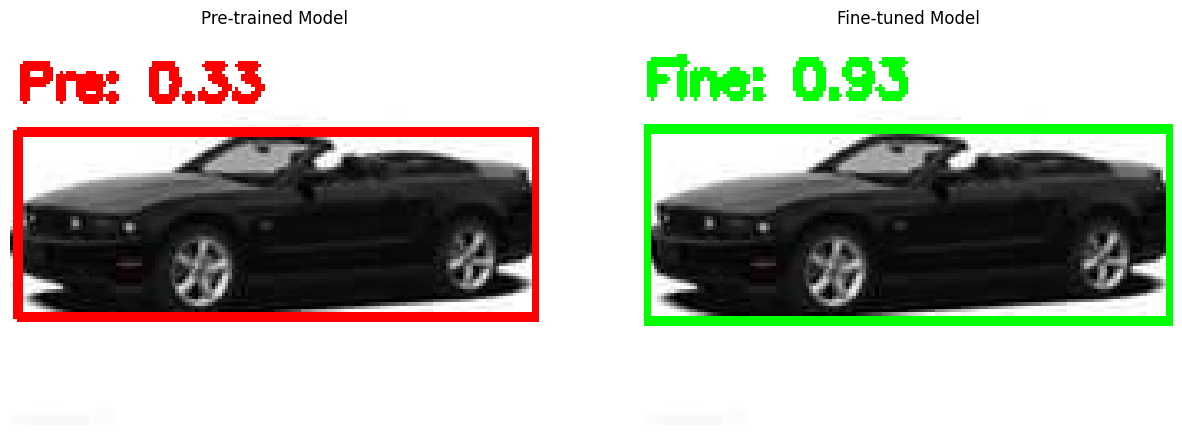

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/00024.jpg"
visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.2)


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00026.jpg: 480x640 1 car, 195.9ms
Speed: 3.8ms preprocess, 195.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00026.jpg: 480x640 1 car, 172.4ms
Speed: 3.1ms preprocess, 172.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


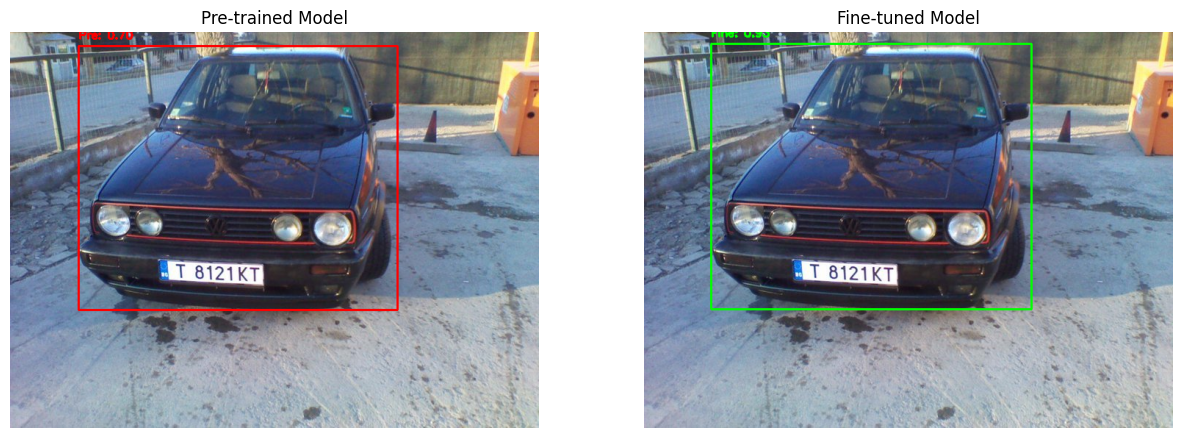

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/00026.jpg"
visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.5)


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00027.jpg: 480x640 2 cars, 423.2ms
Speed: 6.6ms preprocess, 423.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00027.jpg: 480x640 1 car, 196.7ms
Speed: 4.4ms preprocess, 196.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


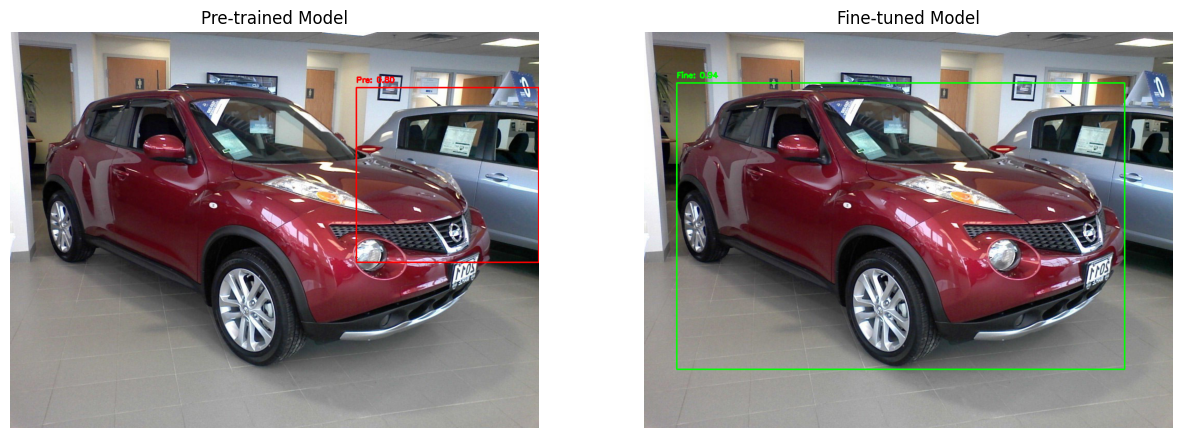

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/00027.jpg"
visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.5)


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00028.jpg: 480x640 2 cars, 341.4ms
Speed: 2.5ms preprocess, 341.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/00028.jpg: 480x640 1 car, 175.2ms
Speed: 2.1ms preprocess, 175.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


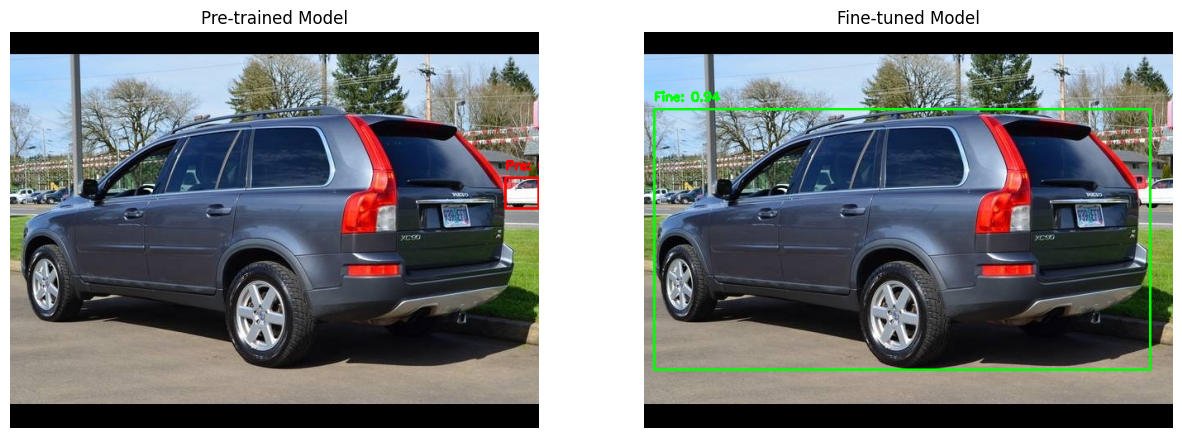

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/00028.jpg"
visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.5)


image 1/1 /content/drive/My Drive/cv_final_project/cars_test/06686.jpg: 480x640 1 car, 1 truck, 208.0ms
Speed: 2.4ms preprocess, 208.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/My Drive/cv_final_project/cars_test/06686.jpg: 480x640 1 car, 174.8ms
Speed: 2.4ms preprocess, 174.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


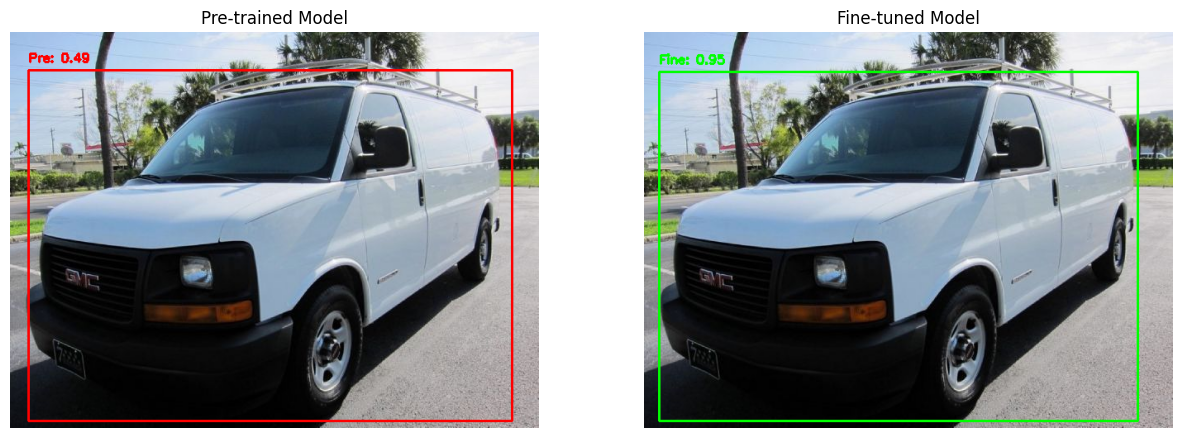

In [ ]:
sample_image_path = "/content/drive/My Drive/cv_final_project/cars_test/06686.jpg"
visualize_most_confident_boxes(sample_image_path, pretrained_model_path, fine_tuned_model_path, conf_threshold=0.2)

Fine-tuned YOLO significantly outperforms pre-trained YOLO in the following scenarios:

- When the image quality is poor
- When the car is viewed from the side or rear
- When there are other secondary vehicles in the background
- When the car model is rare or uncommon